# Gravitational wave production from phase transitions

### Tutorial that shows how to use *cosmoGW* to compute the GW production according to the model of locally stationary UETC validated by Higgsless simulations, which extends the sound-shell model used for weak phase transitions to strong phase transitions where non-linearities develop and the kinetic energy density decays in time

### It follows the description presented in [Caprini:2024gyk]: "Gravitational waves from first-order phase transitions: from weak to strong transitions," *C. Caprini, R. Jinno, T. Konstandin, H. Rubira, A. Roper Pol, I. Stomberg*, JHEP, arXiv:2409.03651

### The results are summarized and presented in [Stomberg:2025]: "Gravitational wave templates for strong cosmological phase transitions," *I. Stomberg and A. Roper Pol*, 2025 Moriond gravitation proceedings

### Created by Alberto Roper Pol (alberto.roperpol@unige.ch), 16/04/2025

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import cosmoGW.plot_sets as plot_sets
import cosmoGW.GW_models as mod
import cosmoGW.GW_analytical as an
import cosmoGW.GW_templates  as tmp
import cosmoGW.hydro_bubbles as hb

cmap = plt.get_cmap('rainbow_r')
darken_factor = .9  # Adjust this factor to control darkness

# reference values
cs2 = hb.cs2_ref    # default value is 1/3
cs  = np.sqrt(cs2)

### The GW spectrum computed from sound waves (compressional motion) can be in general decomposed in the following way:

### $$ \Omega_{\rm GW} = 3 \, \tilde \Omega_{\rm GW} \, {\rm pref} (R_\ast, K) \, F_{\rm GW}^0 (g_\ast) \, S(f), $$ where the prefactor pref depends on the PT parameters: length scale $R_\ast$ and ratio of kinetic to total energy density $K = \rho_{\rm kin}/\rho_{\rm total}$.

### In the following we will present each of these terms for different models and show how one can use CosmoGW to compute the final GW spectrum.

### We start computing the efficiency $\tilde \Omega_{\rm GW}$ using the function *ampl_GWB_sw* in *GW_templates.py* which allows to choose a fixed value, $$\tilde \Omega_{\rm GW} \sim 10^{-2}$$ based on the simulations of Hindmarsh:2017gnf and the sound-shell model (Hindmarsh:2019phv), or to interpolate from the numerical results of Caprini:2024gyk, which considers 3 strengths of the phase transition: $$ \alpha = 0.0046 \ ({\rm weak}), \qquad \alpha = 0.05 \ ({\rm interm})\,, \qquad \alpha = 0.5 \ ({\rm strong})$$

In [2]:
## We can either take it as a fixed value OmGW_sw = 1e-2 for all alpha and vw

OmGWtilde  = tmp.ampl_GWB_sw(model='fixed_value', OmGW_sw=1e-2, vws=[0],
                             alphas=[0], numerical=False, bs_HL=20, quiet=True)

# or interpolate from the results presented in the Higgsless paper

alphas = np.logspace(-3, 0,  30)
vws    = np.linspace(0.1, .99, 50)
    
OmGWtilde = tmp.ampl_GWB_sw(model='higgsless', vws=vws, bs_HL=20,
                            alphas=alphas, numerical=False, quiet=True)

# we can recover the numerical values used to interpolate taking numerical = True
# for bs_HL = 20

_, Omnums20, val_alphas, val_vws  = tmp.ampl_GWB_sw(model='higgsless', vws=vws, alphas=alphas, numerical=True, quiet=True, bs_HL=20)

Text(0.25, 0.0085, 'weak')

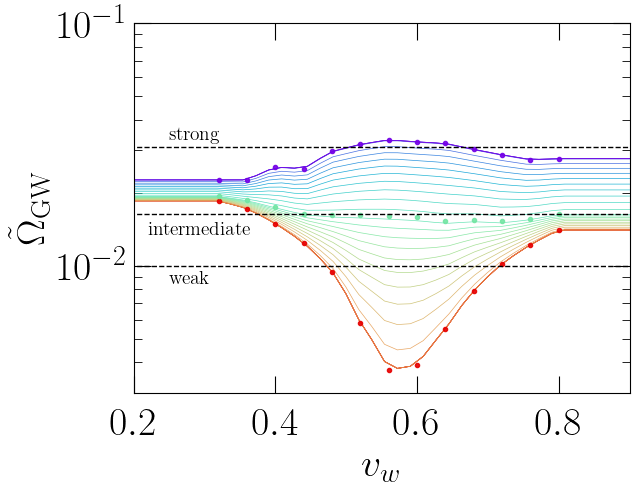

In [3]:
### The result of the interpolated values is shown here, where the black dashed lines
### indicate the amplitudes estimated in Caprini:2024gyk for weak (alpha = 0.0046),
### intermediate (alpha = 0.05) and strong (alpha = 0.5) phase transitions

# color maps
cols = cmap(np.linspace(0, 1, len(alphas)))
cols = tuple(component * darken_factor for component in cols)
cols2 = cmap(np.linspace(0, 1, len(val_alphas)))
cols2 = tuple(component * darken_factor for component in cols2)

for i in range(0, len(alphas)):
    plt.plot(vws, OmGWtilde[:, i], color=cols[i], lw=.5)
for i in range(0, len(val_alphas)):
    plt.plot(val_vws, Omnums20[:, i], '.', color=cols2[i])

plt.xlabel(r'$v_w$')
plt.ylabel(r'$\tilde \Omega_{\rm GW}$')
plt.xlim(0.2, 0.9)
plt.ylim(3e-3, 1e-1)
plt.yscale('log')
plot_sets.axes_lines()

plt.hlines(1e-2, 0.1, 1, color='black', lw=1, ls='dashed')
plt.text(0.25, 3.3e-2, 'strong', fontsize=14)
plt.hlines(1.64e-2, 0.1, 1, color='black', lw=1, ls='dashed')
plt.text(0.22, 1.35e-2, 'intermediate', fontsize=14)
plt.hlines(3.1e-2, 0.1, 1, color='black', lw=1, ls='dashed')
plt.text(0.25, 8.5e-3, 'weak', fontsize=14)

### The prefactor in the GW production is generalized in Caprini:2024gyk based on the locally stationary UETC, such that it can be expressed as

### $$ {\rm pref} = K^2_{\rm exp, int} \, (R_\ast H_\ast),$$ where $$K_{\rm exp, int}^2 = \int_{\tau_\ast}^{\tau_{\rm fin}} \frac{K^2 (\tau)}{\tau^2} {\rm d}\, \tau$$ and $\delta \tau_{\rm fin} = \tau_{\rm fin} - \tau_\ast$ is the sourcing duration in an expanding Universe.

### We will consider the duration to be given in terms of the shock formation time, $$\delta \tau_{\rm fin} = N_{\rm shock} R_\ast/\sqrt{v_{\rm f}^2}$$

### We then first compute the amount of kinetic energy at the end of the phase transition $K_0$. The first approach is to use the description of Espinosa:2010hh, $$K_\xi = \frac{\kappa \alpha}{1 + \alpha},$$ where $\kappa$ is the efficiency factor in the bag equation of state, which can be computed using *kappas_Esp* function in *hydro_bubbles.py*.

### The $v_f$ is the square of the enthalpy-weighted root-mean-square velocity, which we will denote as $\Omega_\xi$, $$\Omega_\xi = v_f^2 = \frac{\langle w \gamma^2 v^2\rangle}{\langle w \rangle} = \frac{\kappa \alpha}{1 + c_{\rm s}^2}$$

In [4]:
vws = np.linspace(0.1, .99, 1000)
K_xi   = hb.kappas_Esp(vws, alphas)*alphas/(1 + alphas)
Oms_xi = hb.kappas_Esp(vws, alphas)*alphas/(1 + cs2)

### Alternatively, we can consider the value of $K(\tau)$ at the end of the phase transition $K_0 = K(\tau_0)$ obtained from the numerical simulations of Caprini:2024gyk

In [5]:
# take values from higgsless dataset
dirr = importlib.resources.open_binary('cosmoGW',
                'resources/higgsless/parameters_fit_sims.csv')
df   = pd.read_csv(dirr)

K0, K0num, _, _ = tmp.interpolate_HL_vals(df, vws, val_alphas, quiet=True, numerical=True,
                               value='curly_K_0_512', boxsize=20)

### We can compare the resulting $K_0$ from both methods. Both are available to compute the prefactor of the GW production using the function *OmGW_spec_sw* in *GW_templates.py* with the options *model_K0* = 'Espinosa' or 'higgsless'

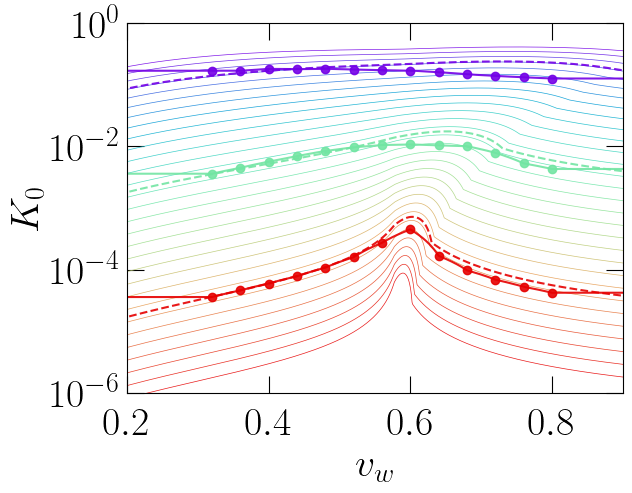

In [6]:
for i in range(0, len(alphas)):
    plt.plot(vws, K_xi[:, i], color=cols[i], lw=.5)

K_xi2 = hb.kappas_Esp(vws, val_alphas)*val_alphas/(1 + val_alphas)
for j in range(0, len(val_alphas)):
    plt.plot(vws, K0[:, j],    color=cols2[j])
    plt.plot(val_vws, K0num[:, j], 'o', color=cols2[j])
    plt.plot(vws, K_xi2[:, j], color=cols2[j], ls='dashed')
   
plt.yscale('log')
plt.ylabel(r'$K_0$')
plt.xlabel(r'$v_w$')
plt.xlim(0.2, 0.9)
plt.ylim(1e-6, 1e0)
plot_sets.axes_lines()

### To compute the duration of the source, which affects the integral $K_{\rm exp, int}^2$ that determines the prefactor of the GW background, we first relate the fluid length scale $R_\ast$ to the nucleation rate of the phase transition $\beta$, $$ R_\ast\beta = (8 \pi)^{1/3} \max(v_w, c_{\rm s})$$

In [7]:
# Range of values of beta/H_ast
betas = np.logspace(1, 5, 9)

# fluid scale given as an array that depends on vws, alphas and betas
lf = np.zeros((len(vws), len(val_alphas), len(betas)))

Rstar_beta = hb.Rstar_beta(vws, corr=True, cs2=cs2)
for i in range(0, len(vws)):
    for j in range(0, len(val_alphas)):
        lf[i, j, :] = hb.Rstar_beta(vws[i], corr=True)/betas

### We then compute the factor $K_{\rm exp, int}^2$ assuming a power-law in time $K(\tau) = K_0 (\tau/\tau_0)^{-b}$, where $b$ is estimated based on the numerical results of Caprini:2024gyk.

### When the decay is negligible ($b \simeq 0$), we recover the GW production from sound waves, which takes the following form when the expansion of the Universe can be neglected, $$K_{\rm int}^2 = K_\xi^2 \delta \tau_{\rm fin} {\cal H}_\ast,$$ and the following one taking into account the expansion in a radiation-dominated Universe, $$K_{\rm int, exp}^2 = K_\xi^2 \Upsilon(\delta \tau_{\rm fin}) = K_\xi^2 \frac{\delta \tau_{\rm fin} {\cal H}_\ast}{1 + \delta \tau_{\rm fin}{\cal H}_\ast}.$$

### These results can be used calling the function *pref_GWB_sw* with *model* = 'sound_waves', or directly calling the function *OmGW_spec_sws* with the option *model_decay* = 'sound_waves'. To take into account expansion of the Universe, these functions should be called with the argument *expansion* = True

### Let us check the evolution with the source duration of the GW amplitude for different values of $\beta/H_\ast$ and compare to the shock formation time for the chosen values of $\alpha = 0.0046, 0.05$ and $0.5$ when there is no decay of the source

Text(0.5, 0, '$\\delta \\tau_{\\rm fin} \\, \\beta$')

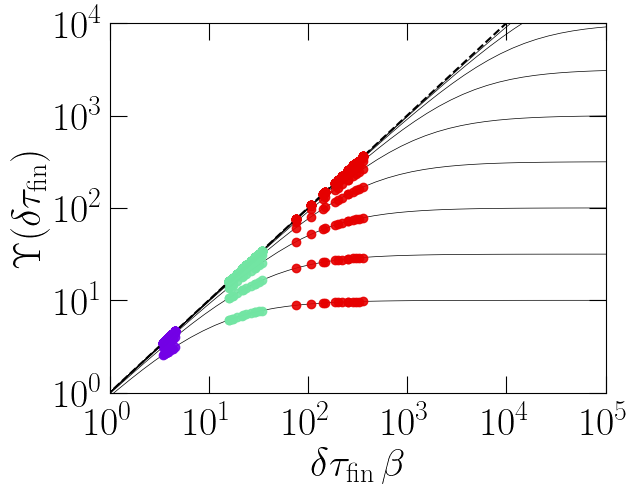

In [8]:
dtfins = np.logspace(-6, 6, 100)
plt.plot(dtfins, dtfins, color='black', ls='dashed')
Ups    = dtfins/(1 + dtfins)

Oms_xi2 = hb.kappas_Esp(val_vws, val_alphas)*val_alphas/(1 + cs2)
for i in range(0, len(betas)):
    lf2   = hb.Rstar_beta(val_vws, corr=True)
    lf2, _ = np.meshgrid(lf2, val_alphas, indexing='ij')
    dtdur = lf2/np.sqrt(Oms_xi2)
    plt.plot(dtfins*betas[i], Ups*betas[i], color='black', lw=.5)
    for j in range(0, len(val_alphas)):
        plt.plot(dtdur[:, j], dtdur[:, j], 'o', color=cols2[j])
        plt.plot(dtdur[:, j], np.interp(dtdur[:, j]/betas[i], dtfins, Ups)*betas[i], 'o', color=cols2[j])

plt.loglog()
plt.xlim(1e0, 1e5)
plt.ylim(1e0, 1e4)
plot_sets.axes_lines()
plt.xticks(np.logspace(0, 5, 6))
plt.yticks(np.logspace(0, 4, 5))
plt.ylabel(r'$\Upsilon (\delta \tau_{\rm fin})$')
plt.xlabel(r'$\delta \tau_{\rm fin} \, \beta$')

### Alternatively, we can take into account the decay of the source calling the function *pref_GWB_sw* with the option *model* = 'decaying' and providing the value of the decay exponent $b$, or directly calling the function *OmGW_spec_sws* with the option *model_decay* = 'decaying'.

### We can also use the values of $b$ interpolated from the numerical results of Caprini:2024gyk, where we note that for some of the phase transition parameters, especially for weak $\alpha$, the values of $b$ might deviate from the physical ones due to underresolution.

In [9]:
# take values from higgsless dataset
b, bnum, _, _ = tmp.interpolate_HL_vals(df, vws, alphas, quiet=True, numerical=True,
                                        value='b', boxsize=20)

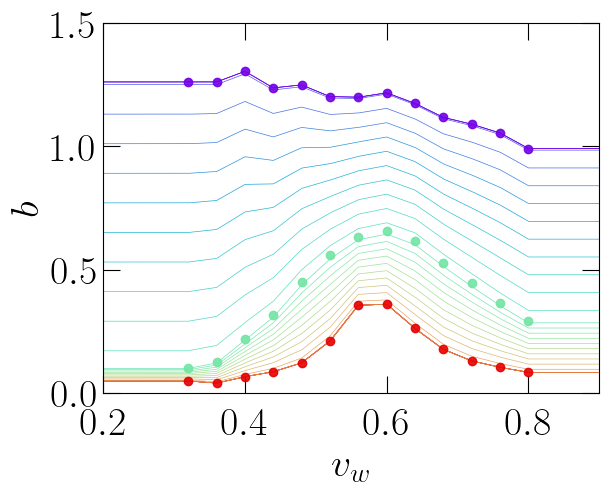

In [26]:
for i in range(0, len(alphas)):
    plt.plot(vws, b[:, i], color=cols[i], lw=.5)
for j in range(0, len(val_alphas)):
    plt.plot(val_vws, bnum[:, j], 'o', color=cols2[j])
   
plt.ylabel(r'$b$')
plt.xlabel(r'$v_w$')
plt.xlim(0.2, 0.9)
plt.ylim(0, 1.5)
plot_sets.axes_lines()

### Taking into account these values of $b$ for the decay, we can again reevaluate the evolution with the source duration of the GW amplitude for different values of $\beta/H_\ast$ and compare to the shock formation time for the chosen values of $\alpha = 0.0046, 0.05$ and $0.5$ including the effect from the decay.

### For this, we can use the function *K2int* provided in the *GW_models.py* routine of *CosmoGW*

Text(0.5, 0, '$\\delta \\tau_{\\rm fin} \\, \\beta$')

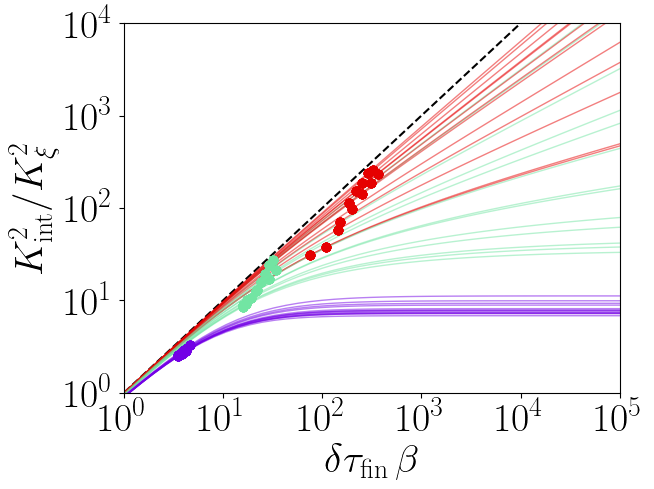

In [38]:
dtfins = np.logspace(-6, 6, 100)

plt.plot(dtfins, dtfins, color='black', ls='dashed')

K2int_flat = np.zeros((len(dtfins), len(val_vws), len(val_alphas)))
for i in range(0, len(val_vws)):
    for j in range(0, len(val_alphas)):
        K2int_flat[:, i, j] = mod.K2int(dtfins, K0=1., b=bnum[i, j], expansion=False)
        plt.plot(dtfins,  K2int_flat[:, i, j], color=cols2[j], alpha=0.5, lw=1)

for i in range(0, len(betas)):
    lf2   = hb.Rstar_beta(val_vws, corr=True)
    lf2, _ = np.meshgrid(lf2, val_alphas, indexing='ij')
    dtdur = lf2/np.sqrt(Oms_xi2)
    # plt.plot(dtfins*betas[i], Ups*betas[i], color='black', lw=.5)
    for j in range(0, len(val_alphas)):
        for l in range(0, len(val_vws)):
            K2int_flat_tdur = mod.K2int(dtdur[l, j], K0=1., b=bnum[l, j], expansion=False)
            plt.plot(dtdur[l, j], K2int_flat_tdur, 'o', color=cols2[j])
        # plt.plot(dtdur[:, j], np.interp(dtdur[:, j]/betas[i], dtfins, Ups)*betas[i], 'o', color=cols2[j])

# K2int_flat0 = mod.K2int(dtfins, K0=1., b=0, expansion=False)
# plt.plot(dtfins, K2int_flat0)

plt.xlim(1e0, 1e4)
plt.ylim(1e0, 1e4)
plt.loglog()

plt.xticks(np.logspace(0, 5, 6))
plt.yticks(np.logspace(0, 4, 5))
plt.ylabel(r'$K^2_{\rm int}/K_\xi^2$')
plt.xlabel(r'$\delta \tau_{\rm fin} \, \beta$')